In [1]:
import sys
sys.path.append("..")
path= "../"

import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import copy
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import h5py
from collections import Counter
import pickle
import os
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use(f'article.mplstyle')

In [2]:
all_df= pd.read_pickle(f"{path}output/pickle_results/real_data.pkl")

## Load results from competitors

In [3]:
sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_sczi.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")

sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_scanpy.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")

sczi = pd.read_pickle(f"{path}output/pickle_results/real_data_scDeepCluster.pkl")
all_df = pd.merge(all_df, sczi, on = ["dataset", "run"], how = "left")
all_df["cluster_number"] = all_df["cluster_number"].astype(int)

In [4]:
all_df["dataset"].unique()

array(['10X_PBMC', '10X_PBMC_select_2100', 'mouse_ES_cell',
       'mouse_ES_cell_select_2100', 'worm_neuron_cell_select_2100',
       'worm_neuron_cell', 'mouse_bladder_cell',
       'mouse_bladder_cell_select_2100'], dtype=object)

In [5]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}
order_dataset ={'10X PBMC': 0,
 '10X PBMC (2100)': 1,
 'Mouse ES\nCell': 2,
 'Mouse ES\nCell (2100)': 3,
 'Worm Neuron\nCell (2100)': 4,
 'Worm Neuron\nCell': 5,
 'Mouse Bladder\nCell': 6,
 'Mouse Bladder\n Cell (2100)': 7}

In [6]:
all_df["dataset"] = all_df["dataset"].apply(lambda x: dataset_names[x])

In [7]:
ours_basic = [
    'kmeans_representation_0', 'kmeans_representation_1',
    'kmeans_representation_2'
]
ours_clust = ['network_0', 'network_1', 'network_2']

df1 = all_df.sort_values(by="cluster_number")

columns = [
    'dataset', 'cluster_number', 'original', 'pca',
    'kmeans_representation_0', 'kmeans_representation_1',
    'kmeans_representation_2', 'network_0', 'network_1', 'network_2', 'sczi',
    'scanpy', 'scDeepCluster', 'COMBINED_kmeans', 'COMBINED_leiden'
]

df1 = df1[columns]

df1 = pd.melt(df1, id_vars=['dataset', 'cluster_number'])


def rename(x):
    if x in ours_basic:
        return "Ours: baseline k-means"
    if x in ours_clust:
        return "Ours: cluster NN"
    if x == 'COMBINED_kmeans':
        return "Ours: ensemble K-means"
    if x == 'COMBINED_leiden':
        return "Ours: ensemble Leiden"
    if x == "pca":
        return "PCA + KMeans"
    if x == "original":
        return "KMeans"
    return x

def order(x):
    if x == "PCA + KMeans":
        return 0
    if x == "KMeans":
        return 1
    if x == 'Seurat':
        return 3
    if x == 'scanpy':
        return 4
    if x == 'sczi':
        return 5
    if x == "scDeepCluster":
        return 6
    if x == "Ours: baseline k-means":
        return 7
    if x == "Ours: cluster NN":
        return 8
    if x == "Ours: ensemble K-means":
        return 9
    if x == "Ours: ensemble Leiden":
        return 10

    return x


df1["variable"] = df1["variable"].apply(rename)
df1 = df1[df1["variable"] != "remove"]
df1["order"] = df1["variable"].apply(order)

In [8]:
df1["dataset_order"] = df1["dataset"].apply(lambda x: order_dataset[x])

In [9]:
df1 = df1.sort_values(by=["dataset_order", "order"], ascending=True)

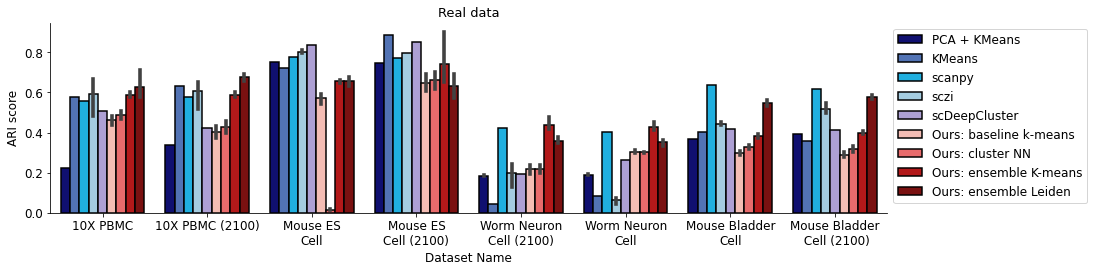

In [10]:
plt.figure(figsize=(15, 3.5))
ax = plt.gca()
clrs = [
    'navy', '#416ec5', 'deepskyblue', '#9acfea', "#a897dd", '#feb6aa',
    '#fd5658', '#cc0001', "darkred"
]
sns.barplot(
    data=df1,
    x="dataset",
    y="value",
    hue="variable",
    palette=clrs,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.xlabel("Dataset Name")
plt.ylabel("ARI score")
plt.title(f"Real data")
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.savefig(f"{path}diagrams/real.pdf", bbox_inches='tight')

In [11]:
df1.to_pickle(f"{path}output/real.pkl")